In [2]:
import os
import sys
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import importlib
import pickle
import numpy as np
import matplotlib as mpl
import colossus.halo.mass_adv as massdefs
from matplotlib.gridspec import GridSpec
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from Functions import Functions as F
from Scripts.CentralPostprocessing import PairFractionData
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1, Args are (Mass, Redshift)
h = Cosmo.h
h_3 = h*h*h

/data/pg1g15/STEEL/Notebooks/Science/../../Scripts/CentralPostprocessing.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('agg')
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=add

In [63]:
from Scripts.Plots import SDSS_Plots
Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)

/data/pg1g15/STEEL/Notebooks/Science/../../Scripts/Plots/SDSS_Plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df_cent.loc[self.Photomotry] = self.df_cent[self.Photomotry] + 0.025


FRACKSKY= 0.1404020420493216


In [3]:
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-0.7,\
'gamma11':0.08\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':True,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris':False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE'\
}

In [4]:
#set plot paramaters here
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15
plt.rcParams['lines.linewidth']=2

get the steel data

In [5]:
def Fit_to_Str(Fit):
    Str_Out = ""
    for i in Fit:
        Str_Out += str(i)+"_"
    return Str_Out
fit_name = Fit_to_Str(('1.0', True, True, True, 'CE', 'G19_SE'))
central_pp_class = pickle.load(open(AbsPath+"/Scripts/CentralPostprocessing/"+fit_name+".pkl", 'rb'))

make the hmf at the redshifts of interest

In [6]:
#Get HMF in massrange 11-15.5
hm_bin = 0.01
hm_min, hm_max = 11.5, 15.5
hm_range = np.arange(hm_min, hm_max, hm_bin) #h^-1
#make HMF at 0.1, 0.5, 1, 2, 3
z = [0.1, 0.2, 0.5, 1, 2, 3]

hmf = HMF_fun(hm_range, z) #N Mpc^-3 h^3 dex^-1

In [81]:
np.log10(HMF_fun(14, 0.1))

array([-4.07984939])

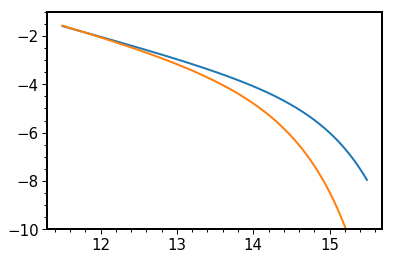

In [62]:
plt.plot(hm_range, np.log10(hmf[0]))
plt.plot(hm_range, np.log10(hmf[3]))
plt.ylim(-10, -1)
plt.show()

pick the volume

In [52]:
#side and volume
side = 500*h #mpc h^-1
vol = side**3 #mpc^3 h^-3
#multiply the HMF appropiately
hmf_vol = hmf*vol*hm_bin #N

Make HM and SM catlouges

In [53]:
hm_range_flip = np.flip(hm_range)
haloes_z = []
galaxies_z = []

for j, hmf_zstep in enumerate(hmf_vol):
    total = 0
    max_mass = hm_range_flip[0]+(hm_bin)
    haloes = np.array([])
    for i, number in enumerate(np.flip(hmf_zstep)):
        total += number
        if total >= 1:
            min_mass = hm_range_flip[i]
            #spawn number of haloes 
            haloes = np.concatenate((haloes, ((max_mass-min_mass)*np.random.random(size = int(total//1)) + min_mass)))
            #any carryover (in theory should also slightly correct max mass but this is egregiously padantic)
            total = total%1
            max_mass = min_mass
    galaxies = F.DarkMatterToStellarMass(haloes-np.log10(h), z[j], Paramaters, ScatterOn = True)
    galaxies_z.append(galaxies)
    haloes_z.append(haloes)
    print("Number of haloes: " + str(len(haloes_z[-1])), end =" ")

Number of haloes: 484404 Number of haloes: 488124 Number of haloes: 489550 Number of haloes: 456740 Number of haloes: 304239 Number of haloes: 149038 

In [54]:
ava_sm_bins[0]

array([0.26032139, 0.25855746, 0.25604564, 0.25216516, 0.24572279,
       0.23592338, 0.22216061, 0.20326151, 0.17989684, 0.15363084,
       0.12753584, 0.10430382, 0.08592436, 0.07236037, 0.06304067,
       0.05679547, 0.05290436, 0.05040274, 0.04886127, 0.04790023,
       0.04731552, 0.04686327, 0.04666035, 0.04659052, 0.04647002,
       0.04619556, 0.04636624, 0.04622809, 0.04617859, 0.04614373,
       0.04609981, 0.04593491, 0.04596051, 0.04603397, 0.04599596,
       0.04566807, 0.04576237, 0.04560877, 0.04561664, 0.04545095,
       0.04542098, 0.04508968, 0.04503399, 0.04529039, 0.04502883,
       0.04450431, 0.04450618, 0.04426801, 0.04411781, 0.04382771,
       0.04371167, 0.04281797, 0.04270568, 0.04323909, 0.04255595,
       0.04128324, 0.04128324])

(array([    0,     0,     0,     0,    34,  2976, 29024, 67737, 71297,
       59624, 48297, 38597, 30502, 24336, 19634, 15957, 13637, 11284,
        9469,  7857,  6634,  5606,  4422,  3693,  3023,  2415,  1968,
        1474,  1226,   912,   663,   565,   432,   323,   232,   158,
         131,    85,    55,    57,    20,    14,    15,     9,     6,
           2,     1,     1,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 8.24191003,  8.50223142,  8.76078888,  9.01683452,  9.26899968,
        9.51472247,  9.75064585,  9.97280646, 10.17606797, 10.3559648 ,
       10.50959565, 10.63713149, 10.74143531, 10.82735967, 10.89972005,
       10.96276071, 11.01955618, 11.07246054, 11.12286328, 11.17172455,
       11.21962478, 11.2669403 , 11.31380356, 11.36046391, 11.40705443,
       11.45352445, 11.49972001, 11.54608625, 11.59231434, 11.63849293,
       11.68463666, 11.73073647, 11.77667138, 11.8226319 , 11.86866587,
       11.91466182, 11.96032989, 12.00609226, 12.051

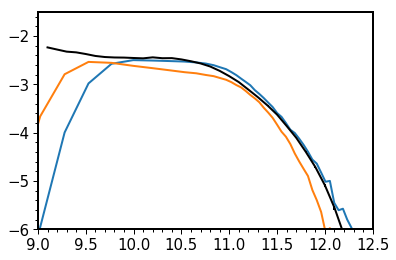

In [84]:
ava_sm_bins = central_pp_class.AvaStellarMassBins
SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data()
plt.errorbar(SMF_Bins[1:], Y_cen[1:], yerr=Y_cen_e[:,1:], color = "k")
Hist = np.histogram(galaxies_z[0], bins = ava_sm[0])
print(Hist)
plt.plot(Hist[1][:-1]-ava_sm_bins[0][:-1], np.log10(Hist[0]/(vol*ava_sm_bins[0][:-1]))+np.log10(h**3))
Hist = np.histogram(galaxies_z[3], bins = ava_sm[0])
print(Hist)
plt.plot(Hist[1][:-1]-ava_sm_bins[0][:-1], np.log10(Hist[0]/(vol*ava_sm_bins[0][:-1]))+np.log10(h**3))
plt.xlim(9, 12.5)
plt.ylim(-6, -1.5)
plt.show()

/home/pg1g15/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pg1g15/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


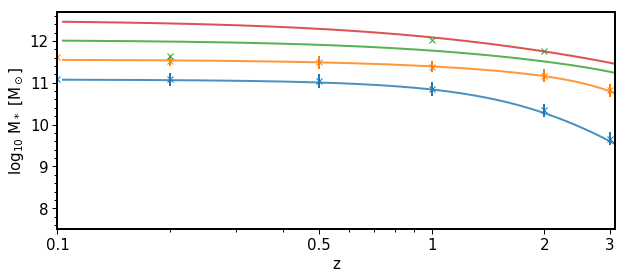

In [12]:
ava_hm = central_pp_class.AvaHaloMass
ava_hm_bins = central_pp_class.AvaHaloMassBins
ava_sm = central_pp_class.AvaStellarMass
ava_sm_bins = central_pp_class.AvaStellarMassBins
z_class = central_pp_class.z


f, plot = plt.subplots(1, 1, figsize = (10, 4))

colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "k"]
colourcycler = cycle(colours)

#arbitrelly picking masses to slice at
hm_slices = [-40, -30, -20, -10]

#loop over the slices
for hm_slice in hm_slices:
    colour = next(colourcycler)
    #get the redshift steps from the catlouge
    z_bins = np.digitize(z, bins = z_class) +1
    hm_at_z = ava_hm[:,hm_slice][z_bins]


    #get the halo masses to make the catlouge cut with
    halo_masses = ava_hm[:,hm_slice][z_bins]
    halo_masses_bin = ava_hm_bins[:,hm_slice][z_bins]

    means, stds = [], []
    for i, z_bin in enumerate(z_bins):
        mask = np.ma.masked_inside(haloes_z[i], halo_masses[i], halo_masses[i]+(halo_masses_bin[i])).mask
        mean, std = np.mean(galaxies_z[i][mask]), np.std(galaxies_z[i][mask])
        #print(galaxies_z[i][mask])
        means.append(mean)
        stds.append(std)

    plot.errorbar(z, means, yerr = stds, fmt = "x", color = colour)
    plot.plot(z_class, ava_sm[:,hm_slice], color = colour, alpha = 50)


plot.set_xlim(0.1, 3.1)
plot.set_xscale("log")
plot.set_xticks([0.1,0.5,1,2,3])
plot.set_xticklabels(["0.1","0.5","1","2","3"])
plot.set_xlabel("z")
plot.set_ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.show()